### Grad-CAM

In [35]:
import torch
import torch.nn as nn
from pytorchvideo.models.hub import x3d_s

num_classes = 5   # 원하는 클래스로 바꿔줘

# 1) pretrained X3D-S 불러오기
model = x3d_s(pretrained=True)

# 2) 전체 파라미터 freeze
for p in model.parameters():
    p.requires_grad = False

# 3) 마지막 projection layer 교체 (fc layer 역할)
in_features = model.blocks[-1].proj.in_features
model.blocks[-1].proj = nn.Linear(in_features, num_classes)

# 4) 새로 교체한 마지막 fc는 학습 가능하게
for p in model.blocks[-1].proj.parameters():
    p.requires_grad = True

checkpoint_path = "./ckpt/best_x3d_s_aug_0.31.pth"
state = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(state)
model.eval()

Net(
  (blocks): ModuleList(
    (0): ResNetBasicStem(
      (conv): Conv2plus1d(
        (conv_t): Conv3d(3, 24, kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1), bias=False)
        (conv_xy): Conv3d(24, 24, kernel_size=(5, 1, 1), stride=(1, 1, 1), padding=(2, 0, 0), groups=24, bias=False)
      )
      (norm): BatchNorm3d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (1): ResStage(
      (res_blocks): ModuleList(
        (0): ResBlock(
          (branch1_conv): Conv3d(24, 24, kernel_size=(1, 1, 1), stride=(1, 2, 2), bias=False)
          (branch2): BottleneckBlock(
            (conv_a): Conv3d(24, 54, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm_a): BatchNorm3d(54, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act_a): ReLU()
            (conv_b): Conv3d(54, 54, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), groups=54, bias=False)
            (nor

In [40]:
class GradCAM3D:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None

        # forward hook 등록
        target_layer.register_forward_hook(self.save_activation)
    
    def save_activation(self, module, input, output):
        self.activations = output
        # gradient hook은 requires_grad=True 확인 후 등록
        if self.activations.requires_grad:
            self.activations.register_hook(self.save_gradient)
    
    def save_gradient(self, grad):
        self.gradients = grad

    def __call__(self, x, class_idx=None):
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        self.model.zero_grad()
        output[:, class_idx].backward()

        weights = self.gradients.mean(dim=(2,3,4), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)
        cam = torch.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        
        # requires_grad=True 텐서이므로 detach 후 numpy 변환
        return cam.squeeze().detach().cpu().numpy()

In [41]:
# 예: 마지막 block 바로 전 layer
target_layer = model.blocks[5].pool.pre_conv

grad_cam = GradCAM3D(model, target_layer)

In [42]:
import torchvision.transforms as transforms
import numpy as np
import cv2

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor()
])

from PIL import Image

def prepare_video_clip(video_frames):
    frames = [transform(Image.fromarray(f)) for f in video_frames]  # numpy → PIL
    clip = torch.stack(frames, dim=1)  # (C, T, H, W)
    return clip.unsqueeze(0)           # (B, C, T, H, W)



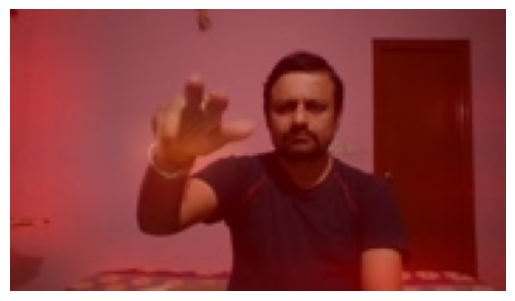

In [57]:
import os
import cv2

def load_video_frames(frame_dir):
    # frame_dir: "./jester_stgcn/frames/0_stop/49462"
    
    # jpg 파일 정렬해서 불러오기 (00001.jpg ~ 00037.jpg)
    frame_files = sorted([
        f for f in os.listdir(frame_dir) 
        if f.endswith(".jpg") or f.endswith(".png")
    ])
    
    frames = []
    for f in frame_files:
        path = os.path.join(frame_dir, f)
        img = cv2.imread(path)        # BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   # RGB로 변환
        frames.append(img)

    return frames  # list of (H, W, 3) numpy arrays
# 1) 프레임 로드
video_dir = "./jester_stgcn/frames/4_background/546"
video_frames = load_video_frames(video_dir)

# 2) 모델 입력 형태로 변환 (B, C, T, H, W)
clip = prepare_video_clip(video_frames)
clip = clip.requires_grad_(True) 

# 3) Grad-CAM 계산 (T, H, W)
cam = grad_cam(clip)

import cv2
import numpy as np
import matplotlib.pyplot as plt

# cam: Grad-CAM 결과 (T, H, W)
t = cam.shape[0] // 2  # 가운데 프레임
heatmap = cam[t]

# 0~255로 변환 후 컬러맵 적용
heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)

# 프레임 크기에 맞게 resize
frame_rgb = video_frames[t]
heatmap_color = cv2.resize(heatmap_color, (frame_rgb.shape[1], frame_rgb.shape[0]))

# overlay
overlay = heatmap_color * 0.5 + frame_rgb * 0.5
overlay = overlay.astype(np.uint8)

plt.imshow(overlay)
plt.axis('off')
plt.show()

In [58]:
overlays = []
for i in range(cam.shape[0]):  # T 프레임 수만큼 반복
    heatmap = cam[i]
    heatmap_color = cv2.applyColorMap((heatmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
    frame_rgb = video_frames[i]
    heatmap_color = cv2.resize(heatmap_color, (frame_rgb.shape[1], frame_rgb.shape[0]))
    
    overlay = heatmap_color * 0.5 + frame_rgb * 0.5
    overlay = overlay.astype(np.uint8)
    overlays.append(overlay)


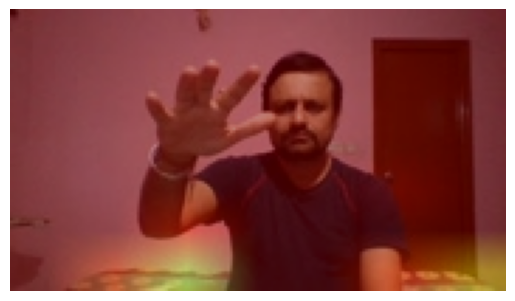

In [59]:
import matplotlib.animation as animation

fig = plt.figure()

im = plt.imshow(overlays[0])
plt.axis('off')

def update(frame):
    im.set_array(frame)
    return [im]

ani = animation.FuncAnimation(fig, update, frames=overlays, interval=50, blit=True)
plt.show()


In [60]:
from IPython.display import HTML

ani = animation.FuncAnimation(fig, update, frames=overlays, interval=50, blit=True)

# 애니메이션을 HTML5 동영상으로 변환 후 출력
HTML(ani.to_jshtml())
